# Data pre-processing and Speckle
Images used for tests are brain medical dataset.

This notebook was run online on Kaggle (https://www.kaggle.com/mahautgrard/mlmi-contour/notebook ).

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename), end='\r')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import json
import csv
import random
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
!pip install imutils
import imutils
import pathlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.nn import Parameter
from torch import Tensor
from torch.optim.optimizer import Optimizer, required
from torch.autograd import Variable
from torch import cuda
from torch.autograd import Variable
from torch.nn.modules.batchnorm import _BatchNorm

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from scipy.ndimage.measurements import label
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

from torchvision import models
from collections import namedtuple

os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import torchvision.utils as vutils
import torchvision.transforms.functional as TF

from IPython.display import display
cudaAvailable = False
if torch.cuda.is_available():
	cudaAvailable = True
Tensor = torch.cuda.FloatTensor if cudaAvailable else torch.Tensor

BCELoss = torch.nn.BCELoss()
L1Loss = torch.nn.L1Loss(reduction='sum')
MSELoss = torch.nn.MSELoss()
#from dataloader import *
#from util import *

You should consider upgrading via the 'c:\python39\python.exe -m pip install --upgrade pip' command.


In [3]:
for dirname, _, filenames in os.walk('/kaggle/input/brats20-sample'):
    for filename in filenames:
        print(os.path.join(dirname, filename), end='\r')

In [5]:
##tests on images read
testa=np.array(Image.open('../BrainTumorDataSet/Testing/glioma/Te-gl_0014.jpg').convert('RGB'))
#print(testa.transpose()[0])
testb=np.array(Image.open('../BrainTumorDataSet/Testing/glioma/Te-gl_0014.jpg'))
#print(testb)
testc = cv2.cvtColor(np.array(Image.open('../BrainTumorDataSet/Testing/glioma/Te-gl_0014.jpg')), cv2.COLOR_HSV2BGR)
testc = cv2.cvtColor(testc, cv2.COLOR_BGR2GRAY)
#print(testc)

# Image filter and speckle
- **Mean filter** : does not removes spekle noise

- **Median filter** : preserves the edges of an image but it does not deal with speckle noise

- **Crimmins smoothing** : removes speckle noise and smooth the edges

https://towardsdatascience.com/image-filters-in-python-26ee938e57d2#:~:text=The%20mean%20filter%20is%20used,the%20edges%20of%20the%20image.

In [6]:
def crimmins(data):
    new_image = data.copy()
    nrow = len(data)
    ncol = len(data[0])
    
    # Dark pixel adjustment
    
    # First Step
    # N-S
    for i in range(1, nrow):
        for j in range(ncol):
            if data[i-1,j] >= (data[i,j] + 2):
                new_image[i,j] += 1
    data = new_image
    # E-W
    for i in range(nrow):
        for j in range(ncol-1):
            if data[i,j+1] >= (data[i,j] + 2):
                new_image[i,j] += 1
    data = new_image
    # NW-SE
    for i in range(1, nrow):
        for j in range(1, ncol):
            if data[i-1,j-1] >= (data[i,j] + 2):
                new_image[i,j] += 1
    data = new_image
    #NE-SW
    for i in range(1, nrow):
        for j in range(ncol-1):
            if data[i-1,j+1] >= (data[i,j] + 2):
                new_image[i,j] += 1
    data = new_image
    # Second Step
    # N-S
    for i in range(1, nrow-1):
        for j in range(ncol):
            if (data[i-1,j] > data[i,j]) and (data[i,j] <= data[i+1,j]):
                new_image[i,j] += 1
    data = new_image
    # E-W
    for i in range(nrow):
        for j in range(1, ncol-1):
            if (data[i,j+1] > data[i,j]) and (data[i,j] <= data[i,j-1]):
                new_image[i,j] += 1
    data = new_image
    # NW-SE
    for i in range(1, nrow-1):
        for j in range(1, ncol-1):
            if (data[i-1,j-1] > data[i,j]) and (data[i,j] <= data[i+1,j+1]):
                new_image[i,j] += 1
    data = new_image
    # NE-SW
    for i in range(1, nrow-1):
        for j in range(1, ncol-1):
            if (data[i-1,j+1] > data[i,j]) and (data[i,j] <= data[i+1,j-1]):
                new_image[i,j] += 1
    data = new_image
    #Third Step
    # N-S
    for i in range(1, nrow-1):
        for j in range(ncol):
            if (data[i+1,j] > data[i,j]) and (data[i,j] <= data[i-1,j]):
                new_image[i,j] += 1
    data = new_image
    # E-W
    for i in range(nrow):
        for j in range(1, ncol-1):
            if (data[i,j-1] > data[i,j]) and (data[i,j] <= data[i,j+1]):
                new_image[i,j] += 1
    data = new_image
    # NW-SE
    for i in range(1, nrow-1):
        for j in range(1, ncol-1):
            if (data[i+1,j+1] > data[i,j]) and (data[i,j] <= data[i-1,j-1]):
                new_image[i,j] += 1
    data = new_image
    # NE-SW
    for i in range(1, nrow-1):
        for j in range(1, ncol-1):
            if (data[i+1,j-1] > data[i,j]) and (data[i,j] <= data[i-1,j+1]):
                new_image[i,j] += 1
    data = new_image
    # Fourth Step
    # N-S
    for i in range(nrow-1):
        for j in range(ncol):
            if (data[i+1,j] >= (data[i,j]+2)):
                new_image[i,j] += 1
    data = new_image
    # E-W
    for i in range(nrow):
        for j in range(1,ncol):
            if (data[i,j-1] >= (data[i,j]+2)):
                new_image[i,j] += 1
    data = new_image
    # NW-SE
    for i in range(nrow-1):
        for j in range(ncol-1):
            if (data[i+1,j+1] >= (data[i,j]+2)):
                new_image[i,j] += 1
    data = new_image
    # NE-SW
    for i in range(nrow-1):
        for j in range(1,ncol):
            if (data[i+1,j-1] >= (data[i,j]+2)):
                new_image[i,j] += 1
    data = new_image
    
    # Light pixel adjustment
    
    # First Step
    # N-S
    for i in range(1,nrow):
        for j in range(ncol):
            if (data[i-1,j] <= (data[i,j]-2)):
                new_image[i,j] -= 1
    data = new_image
    # E-W
    for i in range(nrow):
        for j in range(ncol-1):
            if (data[i,j+1] <= (data[i,j]-2)):
                new_image[i,j] -= 1
    data = new_image
    # NW-SE
    for i in range(1,nrow):
        for j in range(1,ncol):
            if (data[i-1,j-1] <= (data[i,j]-2)):
                new_image[i,j] -= 1
    data = new_image
    # NE-SW
    for i in range(1,nrow):
        for j in range(ncol-1):
            if (data[i-1,j+1] <= (data[i,j]-2)):
                new_image[i,j] -= 1
    data = new_image
    # Second Step
    # N-S
    for i in range(1,nrow-1):
        for j in range(ncol):
            if (data[i-1,j] < data[i,j]) and (data[i,j] >= data[i+1,j]):
                new_image[i,j] -= 1
    data = new_image
    # E-W
    for i in range(nrow):
        for j in range(1, ncol-1):
            if (data[i,j+1] < data[i,j]) and (data[i,j] >= data[i,j-1]):
                new_image[i,j] -= 1
    data = new_image
    # NW-SE
    for i in range(1,nrow-1):
        for j in range(1,ncol-1):
            if (data[i-1,j-1] < data[i,j]) and (data[i,j] >= data[i+1,j+1]):
                new_image[i,j] -= 1
    data = new_image
    # NE-SW
    for i in range(1,nrow-1):
        for j in range(1,ncol-1):
            if (data[i-1,j+1] < data[i,j]) and (data[i,j] >= data[i+1,j-1]):
                new_image[i,j] -= 1
    data = new_image
    # Third Step
    # N-S
    for i in range(1,nrow-1):
        for j in range(ncol):
            if (data[i+1,j] < data[i,j]) and (data[i,j] >= data[i-1,j]):
                new_image[i,j] -= 1
    data = new_image
    # E-W
    for i in range(nrow):
        for j in range(1,ncol-1):
            if (data[i,j-1] < data[i,j]) and (data[i,j] >= data[i,j+1]):
                new_image[i,j] -= 1
    data = new_image
    # NW-SE
    for i in range(1,nrow-1):
        for j in range(1,ncol-1):
            if (data[i+1,j+1] < data[i,j]) and (data[i,j] >= data[i-1,j-1]):
                new_image[i,j] -= 1
    data = new_image
    # NE-SW
    for i in range(1,nrow-1):
        for j in range(1,ncol-1):
            if (data[i+1,j-1] < data[i,j]) and (data[i,j] >= data[i-1,j+1]):
                new_image[i,j] -= 1
    data = new_image
    # Fourth Step
    # N-S
    for i in range(nrow-1):
        for j in range(ncol):
            if (data[i+1,j] <= (data[i,j]-2)):
                new_image[i,j] -= 1
    data = new_image
    # E-W
    for i in range(nrow):
        for j in range(1,ncol):
            if (data[i,j-1] <= (data[i,j]-2)):
                new_image[i,j] -= 1
    data = new_image
    # NW-SE
    for i in range(nrow-1):
        for j in range(ncol-1):
            if (data[i+1,j+1] <= (data[i,j]-2)):
                new_image[i,j] -= 1
    data = new_image
    # NE-SW
    for i in range(nrow-1):
        for j in range(1,ncol):
            if (data[i+1,j-1] <= (data[i,j]-2)):
                new_image[i,j] -= 1
    data = new_image
    return new_image.copy()

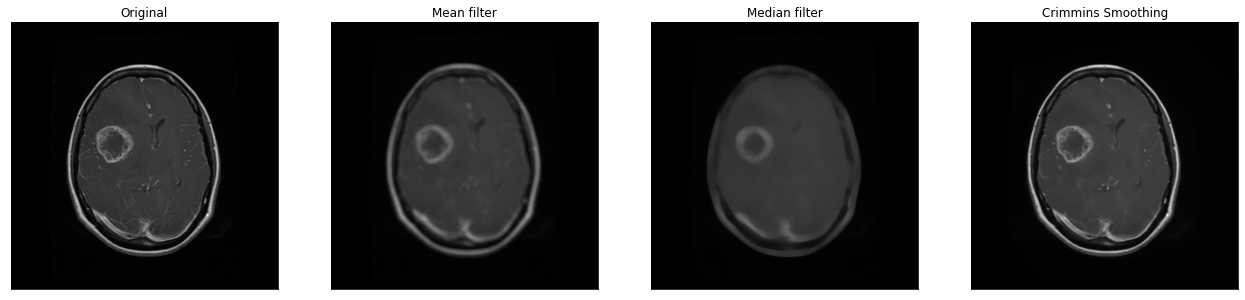

In [8]:
img = 'Te-gl_0014.jpg'
image2=np.array(Image.open('../BrainTumorDataSet/Testing/glioma/'+img).convert('RGB'))
figure_size = 9
#mean filter
new_image = cv2.blur(image2,(figure_size, figure_size))
#median filter
result = ndimage.median_filter(image2, size=20)
#crimmins smoothing
crimmins_image = crimmins(image2.transpose()[0])

            
if not os.path.exists('test/'):
    os.makedirs('test/')
cv2.imwrite('test/'+img, image2)
cv2.imwrite('test/mean_'+img, new_image)
cv2.imwrite('test/median_'+img, result)
cv2.imwrite('test/crimmins_'+img, crimmins_image.transpose())

plt.figure(figsize=(22,6))
plt.subplot(141), plt.imshow(image2, cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(142), plt.imshow(new_image, cmap='gray'),plt.title('Mean filter')
plt.xticks([]), plt.yticks([])
plt.subplot(143), plt.imshow(result, cmap='gray'),plt.title('Median filter')
plt.xticks([]), plt.yticks([])
plt.subplot(144), plt.imshow(crimmins_image.transpose(), cmap='gray'),plt.title('Crimmins Smoothing')
plt.xticks([]), plt.yticks([])
plt.show()

# Image contour

In [10]:
img_array = np.array(Image.open('../BrainTumorDataSet/Testing/glioma/Te-gl_0014.jpg').convert('RGB'))
#Sobel x
img_x = cv2.Sobel(img_array,cv2.CV_64F,1,0,ksize=5)
#Sobel y
img_y = cv2.Sobel(img_array,cv2.CV_64F,0,1,ksize=5)
#Laplacian
img_l = cv2.GaussianBlur(img_array,(3,3),0)
img_l = cv2.Laplacian(img_l,cv2.CV_64F)
#Canny
img_c = cv2.GaussianBlur(img_array,(3,3),0)
img_c = cv2.Canny(img_c,10,70)

img_array2 = np.array(Image.open('./test/Te-gl_0014.jpg').convert('RGB'))
#Sobel x
img_x2 = cv2.Sobel(img_array2,cv2.CV_64F,1,0,ksize=5)
#Sobel y
img_y2 = cv2.Sobel(img_array2,cv2.CV_64F,0,1,ksize=5)
#Laplacian
img_l2 = cv2.GaussianBlur(img_array2,(3,3),0)
img_l2 = cv2.Laplacian(img_l2,cv2.CV_64F)
#Canny
img_c2 = cv2.GaussianBlur(img_array2,(3,3),0)
img_c2 = cv2.Canny(img_c2,10,70)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


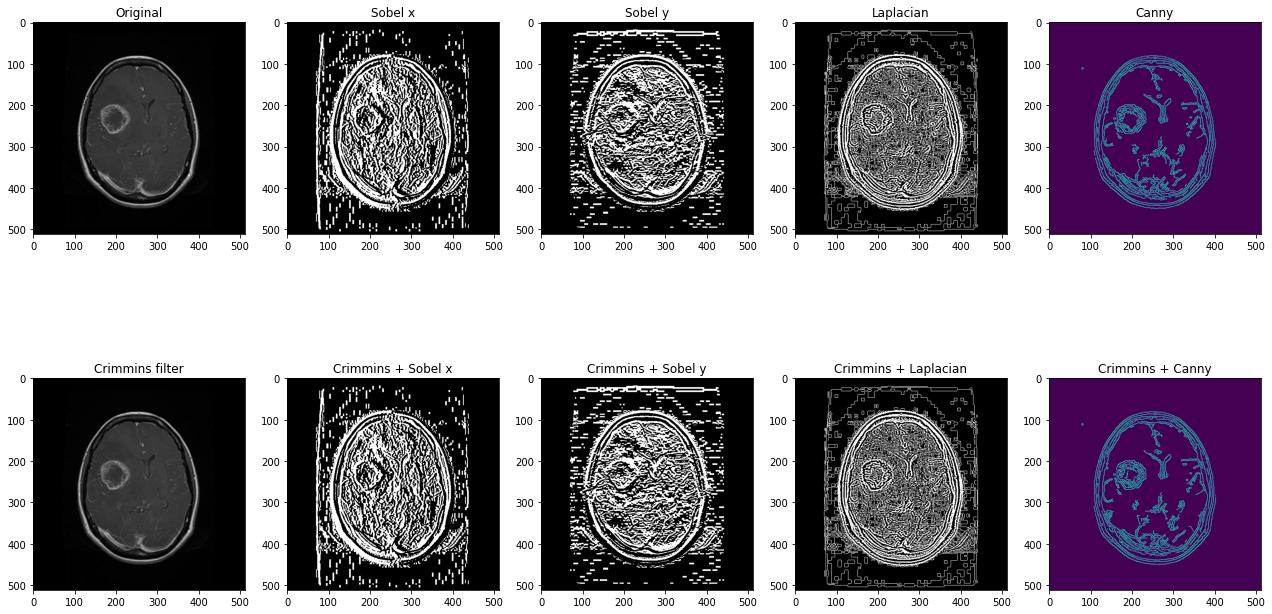

In [11]:
fig=plt.figure(figsize=(22,12))
fig.add_subplot(251)
plt.imshow(img_array)
plt.title("Original")
fig.add_subplot(252)
plt.imshow(img_x)
plt.title("Sobel x")
fig.add_subplot(253)
plt.imshow(img_y)
plt.title("Sobel y")
fig.add_subplot(254)
plt.imshow(img_l)
plt.title("Laplacian")
fig.add_subplot(255)
plt.imshow(img_c)
plt.title("Canny")
fig.add_subplot(256)
plt.imshow(img_array2)
plt.title("Crimmins filter")
fig.add_subplot(257)
plt.imshow(img_x2)
plt.title("Crimmins + Sobel x")
fig.add_subplot(258)
plt.imshow(img_y2)
plt.title("Crimmins + Sobel y")
fig.add_subplot(259)
plt.imshow(img_l2)
plt.title("Crimmins + Laplacian")
fig.add_subplot(2,5, 10)
plt.imshow(img_c2)
plt.title("Crimmins + Canny")
plt.show()

We note that:
- The contours obtained with Canny are the more relevant
- Noticeable "contours" are found for Sobel x, Sobel y and Laplacian contour, as rectangles containing the brain
- These rectangular contours (in the black) tend to dispear or at least are reduced when the Crimmins filter is applied first

# Images preporcessing
https://github.com/masoudnick/Brain-Tumor-MRI-Classification/blob/main/Preprocessing.py

In [20]:
d = {"A": 1, "B": 2}
for elem in d:
    print(elem)

A
B


In [23]:
def crop_img(img):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    # threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    
    return new_img
    
if __name__ == "__main__":
    training = "../BrainTumorDataSet/Training"
    testing = "../BrainTumorDataSet/Testing"
    training_dir = os.listdir(training)
    #print(training_dir)
    testing_dir = os.listdir(testing)
    IMG_SIZE = 256

    for dir in training_dir:
        save_path = 'cleaned/Training/'+ dir
        path = os.path.join(training,dir)
        print(path)
        image_dir = os.listdir(path)
        #print(image_dir)
        for img in image_dir:
            image = cv2.imread(os.path.join(path,img))
            new_img = crop_img(image)
            new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            cv2.imwrite(save_path+'/'+img, new_img)

    for dir in testing_dir:
        save_path = 'cleaned/Testing/'+ dir
        path = os.path.join(testing,dir)
        image_dir = os.listdir(path)
        for img in image_dir:
            image = cv2.imread(os.path.join(path,img))
            new_img = crop_img(image)
            new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            cv2.imwrite(save_path+'/'+img, new_img)

../BrainTumorDataSet/Training\glioma
../BrainTumorDataSet/Training\meningioma
../BrainTumorDataSet/Training\notumor
../BrainTumorDataSet/Training\pituitary


In [14]:
# test for Crimmins filter
cri_img = 'Te-gl_0014.jpg'
cri_image = cv2.imread('./test/'+cri_img)
new_cri_img = crop_img(cri_image)
new_cri_img = cv2.resize(new_cri_img,(IMG_SIZE,IMG_SIZE))
if not os.path.exists('./test'):
    os.makedirs('./test')
cv2.imwrite('./test/cleaned_'+cri_img, new_cri_img)

True

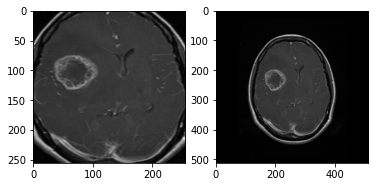

In [3]:
fig=plt.figure()
fig.add_subplot(121)
plt.imshow(np.array(Image.open('./cleaned/Testing/glioma/Te-gl_0014.jpg')))
fig.add_subplot(122)
plt.imshow(np.array(Image.open('../BrainTumorDataSet/Testing/glioma/Te-gl_0014.jpg')))
plt.show()

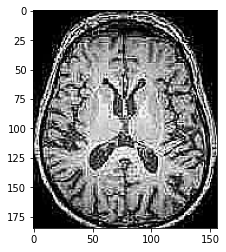

In [17]:
img = cv2.imread('../BrainTumorDataSet/Training/notumor/Tr-no_0786.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (3, 3), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
plt.imshow(new_img)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


256


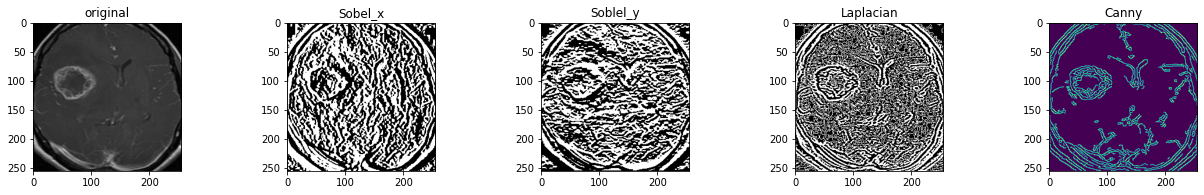

In [17]:
img_array = np.array(Image.open('./cleaned/Testing/glioma/Te-gl_0014.jpg').convert('RGB'))
#Sobel x
img_x = cv2.Sobel(img_array,cv2.CV_64F,1,0,ksize=5)
#Sobel y
img_y = cv2.Sobel(img_array,cv2.CV_64F,0,1,ksize=5)
#Laplacian
img_l = cv2.GaussianBlur(img_array,(3,3),0)
img_l = cv2.Laplacian(img_l,cv2.CV_64F)
#Canny
img_c = cv2.GaussianBlur(img_array,(3,3),0)
img_c = cv2.Canny(img_c,10,70)
print(len(img_c))

fig=plt.figure(figsize=(22,6))
fig.add_subplot(251)
plt.imshow(img_array)
plt.title("original")
fig.add_subplot(252)
plt.imshow(img_x)
plt.title("Sobel_x")
fig.add_subplot(253)
plt.imshow(img_y)
plt.title("Soblel_y")
fig.add_subplot(254)
plt.imshow(img_l)
plt.title("Laplacian")
fig.add_subplot(255)
plt.imshow(img_c)
plt.title("Canny")

plt.show()

We note that:
- The contour works the same with those pre-processed images
- The image pre-processing may cut too much of the brain

# Data augmentation
https://www.kaggle.com/ruslankl/brain-tumor-detection-v1-0-cnn-vgg-16#4.-CNN-Model

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

# os.mkdir('output')
x = np.array(Image.open('./cleaned/Testing/glioma/Te-gl_0014.jpg').convert('RGB')) 
x = x.reshape((1,) + x.shape) 

os.makedirs('preview/')
i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview/', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 
        
plt.imshow(np.array(Image.open('./cleaned/Testing/glioma/Te-gl_0014.jpg').convert('RGB')))
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

We see that rotation, shifting, rescaling, brightness change, and flip where done. It can be usefull for future training.

In [ ]:
###Prepare images used in inference test
img = 'Te-gl_0014.jpg'
image2=np.array(Image.open('./cleaned/Testing/glioma/'+img).convert('RGB'))
figure_size = 9
#mean filter
new_image = cv2.blur(image2,(figure_size, figure_size))
#median filter
result = ndimage.median_filter(image2, size=20)
#crimmins smoothing
crimmins_image = crimmins(image2.transpose()[0])

            
if not os.path.exists('test/'):
    os.makedirs('test/')
cv2.imwrite('test/'+img, image2)
cv2.imwrite('test/mean_cleaned_'+img, new_image)
cv2.imwrite('test/median_cleaned_'+img, result)
cv2.imwrite('test/crimmins_cleaned_'+img, crimmins_image.transpose())

# Binary images -> masks ?

In [ ]:
from PIL import Image, ImageEnhance

#read the image
im = Image.open('./cleaned/Testing/glioma/Te-gl_0014.jpg').convert('RGB')
im1 = np.array(im)
## binary1
ret1, bw_img_1 = cv2.threshold(im1, 127, 255, cv2.THRESH_BINARY)
bw1 = cv2.threshold(im1, 127, 255, cv2.THRESH_BINARY)
bw_img_save0 = Image.fromarray(bw_img_1)
bw_img_save0.save('binary1.jpg')
## masking
image_mask0 = cv2.imread('./binary1.jpg', 0)
thresh = cv2.threshold(image_mask0, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cv2.fillPoly(image_mask0, cnts, [255,255,255])

## image brightness
enhancer = ImageEnhance.Brightness(im)
factor = 1.5 
im_output = enhancer.enhance(factor)
im_output = np.array(im_output)  
## binary 2
ret, bw_img = cv2.threshold(im_output, 127, 255, cv2.THRESH_BINARY)
bw = cv2.threshold(im_output, 127, 255, cv2.THRESH_BINARY)
bw_img_save = Image.fromarray(bw_img)
bw_img_save.save('binary2.jpg')
## masking
image_mask = cv2.imread('./binary2.jpg', 0)
thresh = cv2.threshold(image_mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cv2.fillPoly(image_mask, cnts, [255,255,255])

## with Crimmins filter
im2 = Image.open('./test/cleaned_Te-gl_0014.jpg').convert('RGB')
#image brightness enhancer
enhancer = ImageEnhance.Brightness(im2)
#brightens the image
factor = 1.5 
im_output2 = enhancer.enhance(factor)
im_output2 = np.array(im_output2) 
## binary3
ret2, bw_img2 = cv2.threshold(im_output2, 127, 255, cv2.THRESH_BINARY)
bw2 = cv2.threshold(im_output2, 127, 255, cv2.THRESH_BINARY)
bw_img_save2 = Image.fromarray(bw_img2)
bw_img_save2.save('binary3.jpg')
## masking
image_mask2 = cv2.imread('./binary3.jpg', 0)
thresh = cv2.threshold(image_mask2, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cv2.fillPoly(image_mask2, cnts, [255,255,255])
bw_img_save3 = Image.fromarray(image_mask2)
bw_img_save3.save('mask.jpg')

In [ ]:
fig=plt.figure(figsize=(18,12))
fig.add_subplot(331)
plt.imshow(im)
plt.xticks([])
plt.yticks([])
plt.title("original")
fig.add_subplot(334)
plt.imshow(bw_img_1)
plt.xticks([])
plt.yticks([])
plt.title("binary1")
fig.add_subplot(337)
plt.imshow(image_mask0, cmap="gray")
plt.xticks([])
plt.yticks([])
plt.title("mask1")

fig.add_subplot(332)
plt.imshow(im_output)
plt.xticks([])
plt.yticks([])
plt.title("brigtens")
fig.add_subplot(335)
plt.imshow(bw_img)
plt.xticks([])
plt.yticks([])
plt.title("binary2")
fig.add_subplot(338)
plt.imshow(image_mask, cmap="gray")
plt.xticks([])
plt.yticks([])
plt.title("mask2")

fig.add_subplot(333)
plt.imshow(im_output2)
plt.xticks([])
plt.yticks([])
plt.title("Crimmins + brigtens")
fig.add_subplot(336)
plt.imshow(bw_img2)
plt.xticks([])
plt.yticks([])
plt.title("binary3")
fig.add_subplot(339)
plt.imshow(image_mask2, cmap="gray")
plt.xticks([])
plt.yticks([])
plt.title("mask3")
plt.show()

We combine a binary image with its corresponding filled image ("mask" above):

In [ ]:
hola = cv2.cvtColor(np.array(Image.open('./mask.jpg').convert('RGB')),cv2.COLOR_BGR2GRAY)
#plt.imshow(hola, cmap="gray")
#print(hola)
#print(bw_img_1.transpose()[0])
combinaison = hola-(bw_img.transpose()[0]).transpose()
#print(combinaison[0])
#median filter
final = ndimage.median_filter(combinaison, size=10)
plt.imshow(final, cmap="gray")
plt.title("Combination of binary and filled binary image")
plt.show()

bw_img_save4 = Image.fromarray(final)
bw_img_save4.save('final_mask.jpg')

Removing vertical et horizontal edges:

In [ ]:
# remove vertical & horizontal lines
gray=cv2.cvtColor(np.array(Image.open('./mask.jpg').convert('RGB')),cv2.COLOR_BGR2GRAY)
linek = np.zeros((11,11),dtype=np.uint8)
linek[5,...]=1
x=cv2.morphologyEx(gray, cv2.MORPH_OPEN, linek ,iterations=1)
gray+=x
plt.imshow(gray, cmap="gray")
plt.title("Vertical & Horizontal edge removal")
plt.show()

We note that:
- Removing only vertical and horizontal edges is not efficient, as expected
- Combining binary images with their own filled image gives something that can be used as a tumor mask
- This method is computationaly effective compared to ML techniques to create tumor masks
=> It may be tested in future algorithm as a comparaison

# Brain Tumor paper
Utils

https://github.com/KSH0660/BrainTumor/blob/master/util.py

In [4]:
def gradient_loss_abs(gt, pd, ch=4):
    filter1x = torch.tensor([[1., 2., 1.], [0., 0., 0.], [-1., -2., -1.]])
    filter1y = torch.tensor([[1., 0., -1.], [2., 0., -2.], [1., -0., -1.]])
    # f1_x = filter1x.view((1,1,3,3))
    # f1_y = filter1y.view((1,1,3,3))
    f1_x = torch.zeros([1, ch, 3, 3])
    f1_y = torch.zeros([1, ch, 3, 3])
    for i in range(ch):
        f1_x[0, i, :, :] = filter1x
        f1_y[0, i, :, :] = filter1y
    Tensor = torch.cuda.FloatTensor
    # filter2x = torch.tensor([[2., 2., 4., 2., 2.],[1., 1., 2., 1., 1.]\
    #     , [0., 0., 0., 0., 0.], [-1.,-1., -2., -1., -1.], [-2., -2., -4., -2., -2.]])
    # filter2y = torch.tensor([[2., 1., 0., -1., -2.], [2., 1., 0., -1., -2.] \
    #                             , [4., 2., 0., -2., -4.], [2., 1., 0., -1., -2.], [2., 1., 0., -1., -2.]])

    # f2_x = filter1x.view((1, 1, 5, 5))
    # f2_y = filter1y.view((1, 1, 5, 5))
    f1_x = f1_x.type(Tensor)
    f1_y = f1_y.type(Tensor)
    gt_x_sobel = F.conv2d(gt, f1_x, padding=1)
    gt_y_sobel = F.conv2d(gt, f1_y, padding=1)
    pd_x_sobel = F.conv2d(pd, f1_x, padding=1)
    pd_y_sobel = F.conv2d(pd, f1_y, padding=1)
    loss = torch.mean(torch.abs(gt_x_sobel - pd_x_sobel) + torch.abs(gt_y_sobel - pd_y_sobel))
    return loss

def one2three(x):
    temp = torch.cat([x, x, x], dim=1)
    return temp
def monitor_loss(i, dataloader_len, step=0, tumor_shape_loss=0, tumor_grade_loss=0, inp_gb_loss=0, inp_lc_loss=0, \
                 inp_grad_loss=0, inp_adv_loss=0, content_loss=0, inp_dis_loss=0, mode = 'Train'):
    if step == 0:
        print( "\t[%d/%d]\t Shape loss: %.4f\t Grade loss: %.4f " % (
            i, dataloader_len, tumor_shape_loss, tumor_grade_loss))
    elif step == 1:
        print("\t[%d/%d]\t Inpaint loss G [gb, lc, grad, adv, content]: [%.4f, %.4f, %.4f, %.4f, %.4f] \t Inpaint loss D: %.4f " % (
        i, dataloader_len, inp_gb_loss, inp_lc_loss, inp_grad_loss,inp_adv_loss,content_loss, inp_dis_loss))
    else:
        print("\t[%d/%d]\t Shape loss: %.4f \t Grade loss: %.4f \t Inpaint loss G [gb, lc, grad, adv, content]: [%.4f, %.4f, %.4f, %.4f, %.4f] \t Inpaint loss D: %.4f " % (
            i, dataloader_len, tumor_shape_loss, tumor_grade_loss, inp_gb_loss, inp_lc_loss, inp_grad_loss, inp_adv_loss, content_loss,inp_dis_loss))

    return 0

def save_result(result_dir, epoch, i, step, M=0, Binary_M=0, Circle_M=0, level_Circle_M=0, out_mask_shape=0, out_mask_grade=0, brain=0, uni_B=0, out_brain=0, mode='Train'):

    if mode == 'Train':
        if step == 0 or step == 2:
            result_img = torch.cat((uni_B, Circle_M, out_mask_shape, Binary_M, Binary_M, level_Circle_M, out_mask_grade, M), 0)
            vutils.save_image(result_img, filename=result_dir + "/[%03d]A_%04d.png" % (epoch, i), nrow=4)

        if step == 1 or step == 2:
            F, T1, T1c, T2 = torch.split(brain, split_size_or_sections=1, dim=1)
            out_F, out_T1, out_T1c, out_T2 = torch.split(out_brain, split_size_or_sections=1, dim=1)
            error_F, error_T1, error_T1c, error_T2 = torch.split(torch.abs(brain-out_brain), split_size_or_sections=1, dim=1)
            result_img = torch.cat((F, T1, T1c, T2, out_F, out_T1, out_T1c, out_T2, \
                                    error_F, error_T1, error_T1c, error_T2), 0)
            vutils.save_image(result_img, filename=result_dir + "/[%03d]B_%04d.png" % (epoch, i), nrow=4)

    if mode == 'Test':
        if step == 0 or step == 2:
            F, T1, T1c, T2 = torch.split(brain, split_size_or_sections=1, dim=1)
            out_F, out_T1, out_T1c, out_T2 = torch.split(out_brain, split_size_or_sections=1, dim=1)
            error_F, error_T1, error_T1c, error_T2 = torch.split(torch.abs(brain - out_brain), split_size_or_sections=1, dim=1)
            result_img = torch.cat((uni_B, Circle_M, coarse_mask, refine_mask, F, T1, T1c, T2, out_F, out_T1, out_T1c, out_T2, \
                                    error_F, error_T1, error_T1c, error_T2), 0)
            vutils.save_image(result_img, filename=result_dir + "/[%03d]B_%04d.png" % (epoch, i), nrow=4)

    if step == 1 or step == 2:
        F, T1, T1c, T2 = torch.split(brain, split_size_or_sections=1, dim=1)
        out_F, out_T1, out_T1c, out_T2 = torch.split(out_brain, split_size_or_sections=1, dim=1)
        error_F, error_T1, error_T1c, error_T2 = torch.split(torch.abs(brain - out_brain), split_size_or_sections=1,
                                                             dim=1)
        result_img = torch.cat((F, T1, T1c, T2, out_F, out_T1, out_T1c, out_T2, \
                                error_F, error_T1, error_T1c, error_T2), 0)
        vutils.save_image(result_img, filename=result_dir + "/[%03d]B_%04d.png" % (epoch, i), nrow=4)
def normalize_batch(batch):
    # normalize using imagenet mean and std
    mean = batch.new_tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = batch.new_tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    batch = batch.div_(255.0)
    return (batch - mean) / std

def unify(mask):
    temp = np.zeros(mask.shape)
    temp[np.where(mask>0.3)] = 1
    return torch.from_numpy(temp).float()

def quantize(mask):
    temp = np.zeros(mask.shape)
    temp[np.where(mask > 0.85)]= 1 # ET
    temp[np.where(mask > 0.63) and np.where(mask < 0.85)] = 0.75 # ED
    temp[np.where(mask > 0.36) and np.where(mask < 0.63)] = 0.5 # NET
    temp[np.where(mask < 0.36)] = 0
    return  torch.from_numpy(temp).float()

def random_circle(mask):
    [c, h, w]= mask.shape
    #find radius
    l = random.randint(100,2000)
    radius = int((l/3.14)**(.5))
    #find center
    xx, yy = np.mgrid[:h, :w]

    x_center= random.randint(40,210)
    y_center= random.randint(40,210)

    circle = (xx - x_center) ** 2 + (yy - y_center) ** 2
    circle = circle < radius ** 2
    circle = np.array(np.reshape(circle, [c, h, w]), dtype=np.uint8)
    return torch.from_numpy(circle).float()

def make_circle(mask, radius, x_center, y_center):
    [b, c, h, w]= mask.shape

    xx, yy = np.mgrid[:h, :w]
    circle = (xx - x_center) ** 2 + (yy - y_center) ** 2
    circle = circle < radius ** 2
    circle = np.array(np.reshape(circle, [b, c, h, w]), dtype=np.uint8)

    return torch.from_numpy(circle).float()

def mask2circle(mask, level_shake = False):
    [b, c, h, w]= mask.shape
    # find radius
    l1 = np.array(np.where(mask > 0.1)).shape[1]
    l2 = np.array(np.where(mask > 0.7)).shape[1]
    l3 = np.array(np.where(mask > 0.8)).shape[1]

    if level_shake == True:
        if l1 < 4:
            l1, l2, l3 = 0, 0, 0
        else:
            ran_num = random.sample(range(0,l1), 2)
            ran_num.sort()
            [l3, l2] = ran_num

    radius_1 = int((l1 / 3.14) ** (.5))
    radius_2 = int((l2 / 3.14) ** (.5))
    radius_3 = int((l3 / 3.14) ** (.5))

    xx, yy = np.mgrid[:h, :w]
    nonzero_idx = np.where(mask > 0)
    x_center=np.sum(nonzero_idx[2])/(l1+0.001)
    y_center=np.sum(nonzero_idx[3])/(l1+0.001)

    circle = (xx - x_center) ** 2 + (yy - y_center) ** 2

    temp1 = circle < radius_1**2
    temp1 = temp1*0.5
    temp2 = circle<radius_2 ** 2
    temp2 = temp2*0.25
    temp3 = circle<radius_3 ** 2
    temp3 = temp3*0.25

    temp = temp1 + temp2 + temp3

    result = np.array(np.reshape(temp, [b, c, h, w]))
    return torch.from_numpy(result).float()

def make_level_circle(x_center, y_center, radius_1, radius_2, radius_3 ):
    [b, c, h, w]= [1, 1, 256, 256]
    xx, yy = np.mgrid[:h, :w]
    circle = (xx - x_center) ** 2 + (yy - y_center) ** 2
    temp1 = circle < radius_1 ** 2
    temp1 = temp1*0.25
    temp2 = circle<radius_2 ** 2
    temp2 = temp2*0.25
    temp3 = circle<radius_3 ** 2
    temp3 = temp3*0.5

    temp = temp1 + temp2 + temp3

    result = np.array(np.reshape(temp, [b, c, h, w]))

    return torch.from_numpy(result).float()


def random_circle_generate():
    ran_radius = random.sample(range(5, 35), 3)
    ran_radius.sort()
    [radius3, radius2, radius1] = ran_radius
    ran_center = random.sample(range(80, 170), 2)
    [x_center, y_center] = ran_center

    level_circle = make_level_circle(x_center, y_center, radius3, radius2, radius1)

    return level_circle

def make_aug_dir(Augment_dir):
    pathlib.Path(Augment_dir + 'M').mkdir(parents=True, exist_ok=True)
    pathlib.Path(Augment_dir + 'F').mkdir(parents=True, exist_ok=True)
    pathlib.Path(Augment_dir + 'T1').mkdir(parents=True, exist_ok=True)
    pathlib.Path(Augment_dir + 'T1c').mkdir(parents=True, exist_ok=True)
    pathlib.Path(Augment_dir + 'T2').mkdir(parents=True, exist_ok=True)
    return True

def interpolate_level_circle(mask1, mask2, tot_num=10, idx=0):
    [b, c, h, w]= mask1.shape
    m1_l1 = np.array(np.where(mask1 > 0.24)).shape[1]
    m1_l2 = np.array(np.where(mask1 > 0.49)).shape[1]
    m1_l3 = np.array(np.where(mask1 > 0.74)).shape[1]
    m1_l4 = np.array(np.where(mask1 > 0.99)).shape[1]

    m2_l1 = np.array(np.where(mask2 > 0.24)).shape[1]
    m2_l2 = np.array(np.where(mask2 > 0.49)).shape[1]
    m2_l3 = np.array(np.where(mask2 > 0.74)).shape[1]
    m2_l4 = np.array(np.where(mask2 > 0.99)).shape[1]

    l1 = ((tot_num - idx) * m1_l1 + idx * m2_l1) / tot_num
    l2 = ((tot_num - idx) * m1_l2 + idx * m2_l2) / tot_num
    l3 = ((tot_num - idx) * m1_l3 + idx * m2_l3) / tot_num
    l4 = ((tot_num - idx) * m1_l4 + idx * m2_l4) / tot_num

    radius_1 = int((l1 / 3.14) ** (.5))
    radius_2 = int((l2 / 3.14) ** (.5))
    radius_3 = int((l3 / 3.14) ** (.5))
    radius_4 = int((l4 / 3.14) ** (.5))

    xx, yy = np.mgrid[:h, :w]
    nonzero_idx = np.where(mask1 > 0)
    x_center=np.sum(nonzero_idx[2])/(m1_l1+0.001)
    y_center=np.sum(nonzero_idx[3])/(m1_l1+0.001)
    circle = (xx - x_center) ** 2 + (yy - y_center) ** 2
    temp1 = circle < radius_1**2
    temp1 = temp1*0.25
    temp2 = circle<radius_2 ** 2
    temp2 = temp2*0.25
    temp3 = circle<radius_3 ** 2
    temp3 = temp3*0.25
    temp4 = circle<radius_4 ** 2
    temp4 = temp4*0.25
    temp = temp1 + temp2 + temp3 + temp4

    result = np.array(np.reshape(temp, [b, c, h, w]))
    return torch.from_numpy(result).float()




import glob
from PIL import Image
def make_gif(file_dir, save_dir):
    print(file_dir, save_dir)
    frames=[]
    imgs = glob.glob(file_dir +"/*.png")
    for i in imgs:
        new_frame = Image.open(i)
        frames.append(new_frame)

    frames[0].save(save_dir, format = 'GIF', append_images=frames[1:], save_all=True, duration=300, loop=0)


Inpaint_base_model

In [5]:
class Conv(nn.Module):
    def __init__(self, in_ch, out_ch, K=3, S=1, P=1, D=1, activation=nn.ReLU(inplace=True)):
        super(Conv, self).__init__()
        if activation:
            self.conv = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=K, stride=S, padding=P, dilation=D),
                nn.InstanceNorm2d(out_ch),
                activation
            )
        else:
            self.conv = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=K, stride=S, padding=P, dilation=D),
                nn.InstanceNorm2d(out_ch)
            )

    def forward(self, x):
        x = self.conv(x)
        return x

class PartialConv(nn.Module):
    def __init__(self, in_ch, out_ch, K=3, S=1, P=1, D=1, activation=nn.LeakyReLU(inplace=True)):
        super(PartialConv, self).__init__()
        if activation:
            self.conv = nn.Sequential(
                PartialConv2d(in_ch, out_ch, kernel_size=K, stride=S, padding=P, dilation=D),
                nn.InstanceNorm2d(out_ch),
                activation)
        else:
            self.conv = nn.Sequential(
                PartialConv2d(in_ch, out_ch, kernel_size=K, stride=S, padding=P, dilation=D),
                nn.InstanceNorm2d(out_ch)
            )
    def forward(self, x):
        x = self.conv(x)
        return x

class SN_Conv(nn.Module):
    def __init__(self, in_ch, out_ch, K=3, S=1, P=1, D=1, activation=nn.ReLU(inplace=True)):
        super(SN_Conv, self).__init__()
        self.SpectralNorm = torch.nn.utils.spectral_norm
        if activation:
            self.conv = nn.Sequential(
                self.SpectralNorm(nn.Conv2d(in_ch, out_ch, kernel_size=K, stride=S, padding=P, dilation=D)),
                nn.InstanceNorm2d(out_ch),
                activation
            )
        else:
            self.conv = nn.Sequential(
                self.SpectralNorm(nn.Conv2d(in_ch, out_ch, kernel_size=K, stride=S, padding=P, dilation=D)),
                nn.InstanceNorm2d(out_ch)
            )

    def forward(self, x):
        x = self.conv(x)
        return x


class ResidualBlock(nn.Module):
    def __init__(self, in_features, K=3, S=1, P=1, D=1, activation=nn.ReLU(inplace=True)):
        super(ResidualBlock, self).__init__()

        conv_block = [  Conv(in_features, in_features, K, S, P, D, activation=activation),
                        Conv(in_features, in_features, activation=False)]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

class SN_ResidualBlock(nn.Module):
    def __init__(self, in_features, K=3, S=1, P=1, D=1, activation=nn.LeakyReLU(inplace=True)):
        super(SN_ResidualBlock, self).__init__()
        conv_block = [  SN_Conv(in_features, in_features, K, S, P, D, activation=activation),
                        SN_Conv(in_features, in_features, activation=False)]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

class Partial_ResidualBlock(nn.Module):
    def __init__(self, in_features, K=3, S=1, P=1, D=1, activation=nn.ReLU(inplace=True)):
        super(Partial_ResidualBlock, self).__init__()
        conv_block = [  PartialConv(in_features, in_features, K, S, P, D, activation=activation),
                        PartialConv(in_features, in_features, activation=False)]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

class PartialConv2d(nn.Conv2d):
    def __init__(self, *args, **kwargs):

        # whether the mask is multi-channel or not
        if 'multi_channel' in kwargs:
            self.multi_channel = kwargs['multi_channel']
            kwargs.pop('multi_channel')
        else:
            self.multi_channel = False

        if 'return_mask' in kwargs:
            self.return_mask = kwargs['return_mask']
            kwargs.pop('return_mask')
        else:
            self.return_mask = False

        super(PartialConv2d, self).__init__(*args, **kwargs)

        if self.multi_channel:
            self.weight_maskUpdater = torch.ones(self.out_channels, self.in_channels, self.kernel_size[0],
                                                 self.kernel_size[1])
        else:
            self.weight_maskUpdater = torch.ones(1, 1, self.kernel_size[0], self.kernel_size[1])

        self.slide_winsize = self.weight_maskUpdater.shape[1] * self.weight_maskUpdater.shape[2] * \
                             self.weight_maskUpdater.shape[3]

        self.last_size = (None, None, None, None)
        self.update_mask = None
        self.mask_ratio = None

    def forward(self, input, mask_in=None):
        assert len(input.shape) == 4
        if mask_in is not None or self.last_size != tuple(input.shape):
            self.last_size = tuple(input.shape)

            with torch.no_grad():
                if self.weight_maskUpdater.type() != input.type():
                    self.weight_maskUpdater = self.weight_maskUpdater.to(input)

                if mask_in is None:
                    # if mask is not provided, create a mask
                    if self.multi_channel:
                        mask = torch.ones(input.data.shape[0], input.data.shape[1], input.data.shape[2],
                                          input.data.shape[3]).to(input)
                    else:
                        mask = torch.ones(1, 1, input.data.shape[2], input.data.shape[3]).to(input)
                else:
                    mask = mask_in

                self.update_mask = F.conv2d(mask, self.weight_maskUpdater, bias=None, stride=self.stride,
                                            padding=self.padding, dilation=self.dilation, groups=1)

                self.mask_ratio = self.slide_winsize / (self.update_mask + 1e-8)
                # self.mask_ratio = torch.max(self.update_mask)/(self.update_mask + 1e-8)
                self.update_mask = torch.clamp(self.update_mask, 0, 1)
                self.mask_ratio = torch.mul(self.mask_ratio, self.update_mask)

        # if self.update_mask.type() != input.type() or self.mask_ratio.type() != input.type():
        #     self.update_mask.to(input)
        #     self.mask_ratio.to(input)

        raw_out = super(PartialConv2d, self).forward(torch.mul(input, mask) if mask_in is not None else input)

        if self.bias is not None:
            bias_view = self.bias.view(1, self.out_channels, 1, 1)
            output = torch.mul(raw_out - bias_view, self.mask_ratio) + bias_view
            output = torch.mul(output, self.update_mask)
        else:
            output = torch.mul(raw_out, self.mask_ratio)

        if self.return_mask:
            return output, self.update_mask
        else:
            return output


class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class _BatchInstanceNorm(_BatchNorm):
    def __init__(self, num_features, eps=1e-5, momentum=0.1, affine=True):
        super(_BatchInstanceNorm, self).__init__(num_features, eps, momentum, affine)
        self.gate = Parameter(torch.Tensor(num_features))
        self.gate.data.fill_(1)
        setattr(self.gate, 'bin_gate', True)

    def forward(self, input):
        self._check_input_dim(input)

        # Batch norm
        if self.affine:
            bn_w = self.weight * self.gate
        else:
            bn_w = self.gate
        out_bn = F.batch_norm(
            input, self.running_mean, self.running_var, bn_w, self.bias,
            self.training, self.momentum, self.eps)

        # Instance norm
        b, c = input.size(0), input.size(1)
        if self.affine:
            in_w = self.weight * (1 - self.gate)
        else:
            in_w = 1 - self.gate
        input = input.view(1, b * c, *input.size()[2:])
        out_in = F.batch_norm(
            input, None, None, None, None,
            True, self.momentum, self.eps)
        out_in = out_in.view(b, c, *input.size()[2:])
        out_in.mul_(in_w[None, :, None, None])

        return out_bn + out_in


class BatchInstanceNorm1d(_BatchInstanceNorm):
    def _check_input_dim(self, input):
        if input.dim() != 2 and input.dim() != 3:
            raise ValueError('expected 2D or 3D input (got {}D input)'.format(input.dim()))


class BatchInstanceNorm2d(_BatchInstanceNorm):
    def _check_input_dim(self, input):
        if input.dim() != 4:
            raise ValueError('expected 4D input (got {}D input)'.format(input.dim()))


class BatchInstanceNorm3d(_BatchInstanceNorm):
    def _check_input_dim(self, input):
        if input.dim() != 5:
            raise ValueError('expected 5D input (got {}D input)'.format(input.dim()))

Model

In [6]:
class Inpaint_generator(nn.Module):
    def __init__(self):
        super(Inpaint_generator, self).__init__()

        model = [
            Conv(in_ch=5, out_ch=32, K=3, S=2, P=1),
            Conv(in_ch=32, out_ch=128, K=3, S=2, P=1)
        ]
        for _ in range(3):
            model += [ResidualBlock(128)]
        self.model_initial = nn.Sequential(*model)

        model = [Conv(in_ch=1, out_ch=4, K=3, S=2, P=1),
                 Conv(in_ch=4, out_ch=16, K=3, S=2, P=1)]
        self.model_Mask = nn.Sequential(*model)

        model = [Conv(in_ch=144, out_ch=256, K=3, S=1, P=1),
                 ResidualBlock(256),
                 nn.Upsample(scale_factor=2, mode='nearest'), Conv(
                     256, 128, 3, 1, 1),
                 ResidualBlock(128),
                 nn.Upsample(scale_factor=2, mode='nearest'), Conv(
                     128, 64, 3, 1, 1),
                 ResidualBlock(64),
                 Conv(in_ch=64, out_ch=1, K=7, S=1, P=3),
                 ]
        self.model_F = nn.Sequential(*model)

        model = [Conv(in_ch=144, out_ch=256, K=3, S=1, P=1),
                 ResidualBlock(256),
                 nn.Upsample(scale_factor=2, mode='nearest'), Conv(
                     256, 128, 3, 1, 1),
                 ResidualBlock(128),
                 nn.Upsample(scale_factor=2, mode='nearest'), Conv(
                     128, 64, 3, 1, 1),
                 ResidualBlock(64),
                 Conv(in_ch=64, out_ch=1, K=7, S=1, P=3),
                 ]
        self.model_T1 = nn.Sequential(*model)

        model = [Conv(in_ch=144, out_ch=256, K=3, S=1, P=1),
                 ResidualBlock(256),
                 nn.Upsample(scale_factor=2, mode='nearest'), Conv(
                     256, 128, 3, 1, 1),
                 ResidualBlock(128),
                 nn.Upsample(scale_factor=2, mode='nearest'), Conv(
                     128, 64, 3, 1, 1),
                 ResidualBlock(64),
                 Conv(in_ch=64, out_ch=1, K=7, S=1, P=3),
                 ]
        self.model_T1c = nn.Sequential(*model)

        model = [Conv(in_ch=144, out_ch=256, K=3, S=1, P=1),
                 ResidualBlock(256),
                 nn.Upsample(scale_factor=2, mode='nearest'), Conv(
                     256, 128, 3, 1, 1),
                 ResidualBlock(128),
                 nn.Upsample(scale_factor=2, mode='nearest'), Conv(
                     128, 64, 3, 1, 1),
                 ResidualBlock(64),
                 Conv(in_ch=64, out_ch=1, K=7, S=1, P=3),
                 ]
        self.model_T2 = nn.Sequential(*model)

    def forward(self, brain_blank, M):
        x = self.model_initial(torch.cat((brain_blank, M), 1))
        M = self.model_Mask(M)
        x = torch.cat((x, M), 1)
        F, T1, T1c, T2 = self.model_F(x), self.model_T1(
            x), self.model_T1c(x), self.model_T2(x)
        return torch.cat((F, T1, T1c, T2), 1)

In [7]:
class Tumor_shape(nn.Module):
    def __init__(self, input_nc=2):
        super(Tumor_shape, self).__init__()

        # Down sampling
        model = [Conv(in_ch=input_nc, out_ch=32, K=5, S=1,
                      P=2, activation=nn.LeakyReLU())]
        model += [Conv(in_ch=32, out_ch=64, K=3, S=2,
                       P=1, activation=nn.LeakyReLU())]
        model += [Conv(in_ch=64, out_ch=128, K=3, S=2,
                       P=1, activation=nn.LeakyReLU())]
        model += [Conv(in_ch=128, out_ch=256, K=3, S=2,
                       P=1, activation=nn.LeakyReLU())]

        for _ in range(3):
            model += [SN_ResidualBlock(256, activation=nn.LeakyReLU())]

        # Upsampling
        model += [nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
                  nn.InstanceNorm2d(128),
                  nn.LeakyReLU(inplace=True)]
        model += [nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
                  nn.InstanceNorm2d(64),
                  nn.LeakyReLU(inplace=True)]
        model += [nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
                  nn.InstanceNorm2d(32),
                  nn.LeakyReLU(inplace=True)]

        model += [Conv(in_ch=32, out_ch=1, K=5, S=1,
                       P=2, activation=nn.LeakyReLU())]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        x = self.model(x)
        return x


class Tumor_grade(nn.Module):
    def __init__(self, input_nc=2):
        super(Tumor_grade, self).__init__()
        # Down sampling
        model = [Conv(in_ch=input_nc, out_ch=32, K=5, S=1,
                      P=2, activation=nn.LeakyReLU())]
        model += [Conv(in_ch=32, out_ch=64, K=3, S=2,
                       P=1, activation=nn.LeakyReLU())]
        model += [Conv(in_ch=64, out_ch=128, K=3, S=2,
                       P=1, activation=nn.LeakyReLU())]
        model += [Conv(in_ch=128, out_ch=256, K=3, S=2,
                       P=1, activation=nn.LeakyReLU())]
        for _ in range(3):
            model += [SN_ResidualBlock(256, activation=nn.LeakyReLU())]
        # Upsampling
        model += [nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
                  nn.InstanceNorm2d(128),
                  nn.LeakyReLU(inplace=True)]
        model += [nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
                  nn.InstanceNorm2d(64),
                  nn.LeakyReLU(inplace=True)]
        model += [nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
                  nn.InstanceNorm2d(32),
                  nn.LeakyReLU(inplace=True)]
        model += [Conv(in_ch=32, out_ch=1, K=5, S=1,
                       P=2, activation=nn.LeakyReLU())]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        x = self.model(x)
        return x


Losses

In [8]:
def realTargetLoss(x):
	target = Tensor(x.shape[0], 1).fill_(1.0)
	return MSELoss(x, target)

def fakeTargetLoss(x):
	target = Tensor(x.shape[0], 1).fill_(0.0)
	return MSELoss(x, target)

def cycleLoss(a, a_):
	loss = MSELoss(a, a_)
	return loss

def VAE_loss(recon_x, x, mu, logvar):
	BCE = reconstruction_function(recon_x, x)  # mse loss
	KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
	KLD = torch.sum(KLD_element).mul_(-0.5)
	return BCE + KLD

# Inference test from Brain Tumor paper

In [9]:
tumor_shape = Tumor_shape().cuda()
tumor_grade = Tumor_grade().cuda()
inp_gen = Inpaint_generator().cuda()

In [10]:
tumor_shape.load_state_dict(torch.load('../input/masks/tumor_shape.pth'))
tumor_grade.load_state_dict(torch.load('../input/masks/tumor_grade.pth'))
inp_gen.load_state_dict(torch.load("../input/masks/inp_gen.pth"))

print('model uploaded')

model uploaded


In [69]:
#brats
flair_test_img_list = glob.glob('../input/brats20-sample/BraTS20_Training_001_flair_61.png')
t1ce_test_img_list = glob.glob('../input/brats20-sample/BraTS20_Training_001_t1ce_61.png')
t1_test_img_list = glob.glob('../input/brats20-sample/BraTS20_Training_001_t1_61.png')
t2_test_img_list = glob.glob('../input/brats20-sample/BraTS20_Training_001_t2_61.png')

print("len:", len(flair_test_img_list), len(t1ce_test_img_list), len(t1_test_img_list), len(t2_test_img_list))

len: 1 1 1 1


In [70]:
# test_image_list
glioma_test_img_list = glob.glob('./cleaned/Testing/glioma/*.jpg')
meningioma_test_img_list = glob.glob('./cleaned/Testing/meningioma/*.jpg')
notumor_test_img_list = glob.glob('./cleaned/Testing/notumor/*.jpg')
pituitary_test_img_list = glob.glob('./cleaned/Testing/pituitary/*.jpg')

print("len:", len(glioma_test_img_list), len(meningioma_test_img_list), len(notumor_test_img_list), len(pituitary_test_img_list))

len: 0 0 0 0


In [71]:
flair_test_img_list[0]

'../input/brats20-sample/BraTS20_Training_001_flair_61.png'

shape: (240, 240) 
 range of img: 30 ~ 215


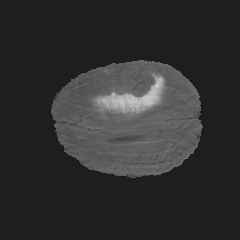

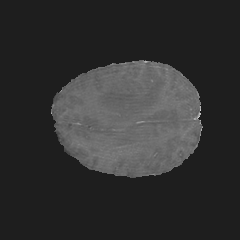

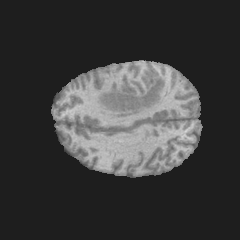

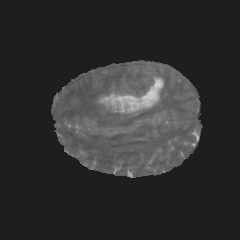

In [72]:
# brats sample
temp_flair = cv2.imread(flair_test_img_list[0], 0) 
temp_t1ce = cv2.imread(t1ce_test_img_list[0], 0)
temp_t1 = cv2.imread(t1_test_img_list[0], 0)
temp_t2 = cv2.imread(t2_test_img_list[0], 0)
#temp_pituitary = cv2.imread(pituitary_test_img_list[temp_idx], 0)
print('shape:', temp_flair.shape, '\n', 'range of img:', temp_flair.min(), '~', temp_flair.max())

display(Image.fromarray(temp_flair))
display(Image.fromarray(temp_t1ce))
display(Image.fromarray(temp_t1))
display(Image.fromarray(temp_t2))

In [ ]:
# load one image
#temp_idx = 30 # it can be modified
temp_glioma = cv2.imread('./cleaned/Testing/glioma/Te-gl_0014.jpg', 0) 
temp_meningioma = cv2.imread('./test/mean_cleaned_Te-gl_0014.jpg', 0)
temp_notumor = cv2.imread('./test/median_cleaned_Te-gl_0014.jpg', 0)
temp_pituitary = cv2.imread('./test/crimmins_cleaned_Te-gl_0014.jpg', 0)
#temp_pituitary = cv2.imread(pituitary_test_img_list[temp_idx], 0)
print('shape:', temp_glioma.shape, '\n', 'range of img:', temp_glioma.min(), '~', temp_glioma.max())

display(Image.fromarray(temp_glioma))
display(Image.fromarray(temp_meningioma))
display(Image.fromarray(temp_notumor))
display(Image.fromarray(temp_pituitary))

Mask from circle and pre-trained model:

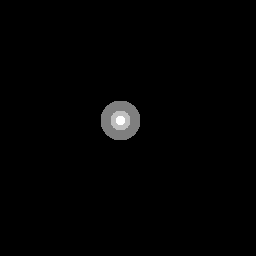

In [74]:
# Set level circle
temp_circle = make_level_circle(x_center = 120,y_center = 120, radius_1 = 5, radius_2 = 10,radius_3 = 20)
display(Image.fromarray(temp_circle[0][0].numpy()*255).convert('RGB'))

In [75]:
temp_circle.shape

torch.Size([1, 1, 256, 256])

(256, 256)


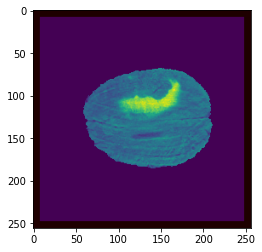

In [76]:
# resizing the image
old_im = Image.open('../input/brats20-sample/BraTS20_Training_001_flair_61.png')
old_size = old_im.size

new_size = (256, 256)
new_im = Image.new("RGB", new_size, 30)   ## luckily, this is already black!
new_im.paste(old_im, ((new_size[0]-old_size[0])//2,
                      (new_size[1]-old_size[1])//2))
print(new_im.size)
plt.imshow(new_im)
plt.show()

In [77]:
old_size = old_im.size
new_size = (256, 256)

old_flair = Image.fromarray(temp_flair)
new_temp_flair = Image.new("RGB", new_size, 30)   ## luckily, this is already black!
new_temp_flair.paste(old_flair, ((new_size[0]-old_size[0])//2,(new_size[1]-old_size[1])//2))
new_temp_flair = np.array(new_temp_flair)[:,:,0]

old_t1ce = Image.fromarray(temp_t1ce)
new_temp_t1ce = Image.new("RGB", new_size, 30)   ## luckily, this is already black!
new_temp_t1ce.paste(old_t1ce, ((new_size[0]-old_size[0])//2,(new_size[1]-old_size[1])//2))
new_temp_t1ce = np.array(new_temp_t1ce)[:,:,0]

old_t1 = Image.fromarray(temp_t1)
new_temp_t1 = Image.new("RGB", new_size, 30)   ## luckily, this is already black!
new_temp_t1.paste(old_t1, ((new_size[0]-old_size[0])//2,(new_size[1]-old_size[1])//2))
new_temp_t1 = np.array(new_temp_t1)[:,:,0]

old_t2 = Image.fromarray(temp_t2)
new_temp_t2 = Image.new("RGB", new_size, 30)   ## luckily, this is already black!
new_temp_t2.paste(old_t2, ((new_size[0]-old_size[0])//2,(new_size[1]-old_size[1])//2))
new_temp_t2 = np.array(new_temp_t2)[:,:,0]

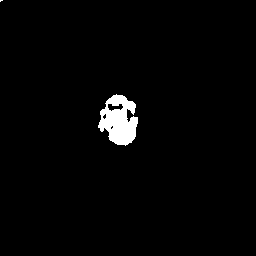

In [78]:
# Make a Binary Mask
with torch.no_grad():
    binary_circle = unify(temp_circle).reshape(1,1,256,256)
    binary_circle_torch = binary_circle.cuda()
    uni_B = unify(new_temp_flair).reshape(1,1,256,256)
    uni_B_torch = uni_B.cuda()
    
    binary_mask = unify(tumor_shape(torch.cat([uni_B_torch, binary_circle_torch], 1)).detach().cpu().numpy())
    binary_mask_torch = binary_mask.cuda()

    display(Image.fromarray(binary_mask[0][0].numpy()*255).convert('RGB'))

Or mask from images and masks from previous section:

In [ ]:
##OR
# Make a Binary Mask from final_mask
with torch.no_grad():
    #print(binary_mask.size())
    #t_bi = torch.from_numpy(np.array(Image.open('./binary3.jpg').convert('RGB')).transpose())[0]
    #t_bi = t_bi.type(torch.FloatTensor)
    #print(t_bi.type())
    t_mask = torch.from_numpy(np.array(Image.open('./final_mask.jpg').convert('RGB')).transpose())[0]
    t_mask = t_mask.type(torch.FloatTensor)
    t_mask = torch.reshape(t_mask, (1, 1, 256, 256))
    print(t_mask.size())
    display(Image.fromarray(t_mask[0][0].numpy()).convert('RGB'))
    
    
    binary_circle = unify(temp_circle).reshape(1,1,256,256)
    binary_circle_torch = binary_circle.cuda()
    uni_B = unify(temp_glioma).reshape(1,1,256,256)
    uni_B_torch = uni_B.cuda()
    
    binary_mask = unify(tumor_shape(torch.cat([uni_B_torch, binary_circle_torch], 1)).detach().cpu().numpy())
    binary_mask_torch = t_mask.cuda()

Result from the pre-trained mask:

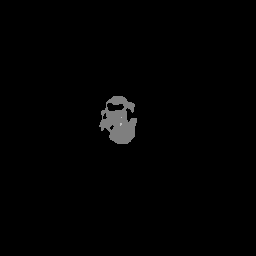

In [79]:
# Make a Grade Mask
with torch.no_grad():
    temp_circle_torch = temp_circle.float().cuda()
    grade_mask = quantize(tumor_grade(torch.cat([binary_mask_torch, temp_circle_torch], 1)).detach().cpu().numpy())
    grade_mask_torch = grade_mask.cuda()
    
    display(Image.fromarray(grade_mask[0][0].numpy()*255).convert('RGB'))

results without merging


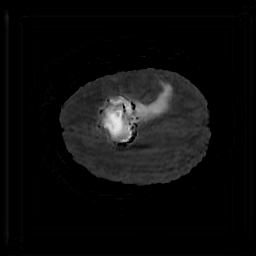

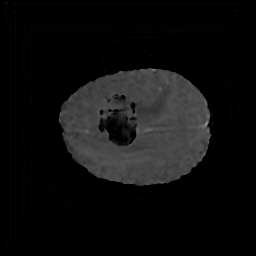

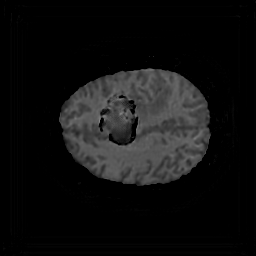

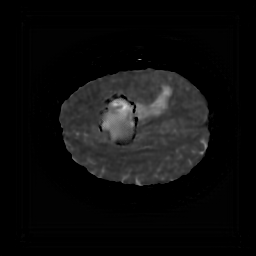

results with merging


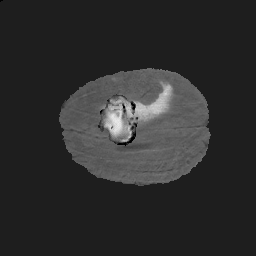

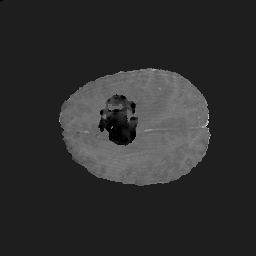

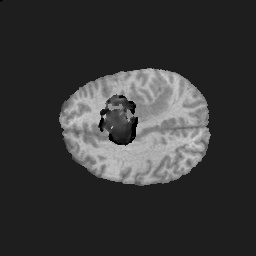

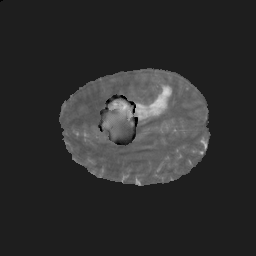

In [80]:
# inpaint
transforms_ = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor()])

with torch.no_grad():
    temp_flair_torch = transforms_(new_temp_flair).reshape(1,1,256,256)
    temp_t1ce_torch = transforms_(new_temp_t1ce).reshape(1,1,256,256)
    temp_t1_torch = transforms_(new_temp_t1).reshape(1,1,256,256)
    temp_t2_torch = transforms_(new_temp_t2).reshape(1,1,256,256)
    
    brain_torch = torch.cat((temp_flair_torch, temp_t1ce_torch, temp_t1_torch, temp_t2_torch), 1).cuda()
    brain_blank_torch = (brain_torch * (1-binary_mask_torch))

    out_brain_torch = inp_gen(brain_blank_torch, grade_mask_torch)
    flair_, t1ce_, t1_, t2_ = torch.split(out_brain_torch.detach().cpu(),split_size_or_sections=1, dim=1)
    
    print('results without merging')
    display(Image.fromarray(flair_[0][0].numpy()*255).convert('RGB'))
    display(Image.fromarray(t1ce_[0][0].numpy()*255).convert('RGB'))
    display(Image.fromarray(t1_[0][0].numpy()*255).convert('RGB'))
    display(Image.fromarray(t2_[0][0].numpy()*255).convert('RGB'))

    # merge with noraml brain (at non-tumor parts)
    print('results with merging')
    out_brain_final = out_brain_torch * binary_mask_torch + brain_torch * (1-binary_mask_torch)
    flair_final, t1ce_final, t1_final, t2_final = torch.split(out_brain_final.detach().cpu(),split_size_or_sections=1, dim=1)

    display(Image.fromarray(flair_final[0][0].numpy()*255).convert('RGB'))
    display(Image.fromarray(t1ce_final[0][0].numpy()*255).convert('RGB'))
    display(Image.fromarray(t1_final[0][0].numpy()*255).convert('RGB'))
    display(Image.fromarray(t2_final[0][0].numpy()*255).convert('RGB'))